GPT ARCHITECTURE PART 1:  IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [130]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

GPT ARCHITECTURE PART1 : DUMMY GPT MODEL CLASS

Step1 : Use a placeholder for Transformer block

Step2 : Use a placeholder for Layer Norm

In [131]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    #Use a placeholder transformer block
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Use a placeholder for Layer Norm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    print(batch_size)
    print(seq_len)
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x



STEP1 : TOKENIZATION

In [132]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


STEP2 : CREATE AN INSTANCE OF DUMMY GPT MODEL


In [133]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

2
4
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

In [134]:
import torch
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [135]:
mean = out.mean(dim=-1,keepdim=True)
print(mean)
var = out.var(dim=-1,keepdim=True)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [136]:
out_norm = (out - mean)/torch.sqrt(var)
print(out_norm)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print(mean)
print(var)

torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [137]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps) # eps added to avoid divide by zero error while normalizing
    return self.scale * norm_x + self.shift

In [138]:
ln = LayerNorm(emb_dim = 5)
print(batch_example)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,keepdim=True, unbiased=False)
print(mean)
print(var)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU

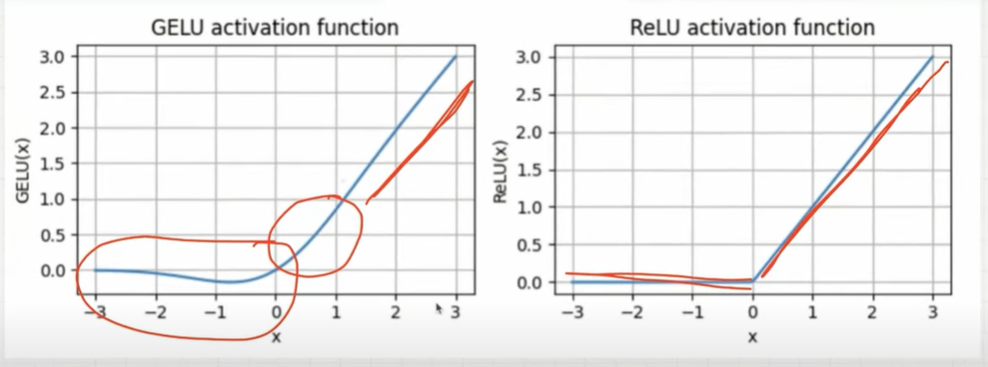

In [139]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

tensor([-3.0000, -2.9394, -2.8788, -2.8182, -2.7576, -2.6970, -2.6364, -2.5758,
        -2.5152, -2.4545, -2.3939, -2.3333, -2.2727, -2.2121, -2.1515, -2.0909,
        -2.0303, -1.9697, -1.9091, -1.8485, -1.7879, -1.7273, -1.6667, -1.6061,
        -1.5455, -1.4848, -1.4242, -1.3636, -1.3030, -1.2424, -1.1818, -1.1212,
        -1.0606, -1.0000, -0.9394, -0.8788, -0.8182, -0.7576, -0.6970, -0.6364,
        -0.5758, -0.5152, -0.4545, -0.3939, -0.3333, -0.2727, -0.2121, -0.1515,
        -0.0909, -0.0303,  0.0303,  0.0909,  0.1515,  0.2121,  0.2727,  0.3333,
         0.3939,  0.4545,  0.5152,  0.5758,  0.6364,  0.6970,  0.7576,  0.8182,
         0.8788,  0.9394,  1.0000,  1.0606,  1.1212,  1.1818,  1.2424,  1.3030,
         1.3636,  1.4242,  1.4848,  1.5455,  1.6061,  1.6667,  1.7273,  1.7879,
         1.8485,  1.9091,  1.9697,  2.0303,  2.0909,  2.1515,  2.2121,  2.2727,
         2.3333,  2.3939,  2.4545,  2.5152,  2.5758,  2.6364,  2.6970,  2.7576,
         2.8182,  2.8788,  2.9394,  3.00

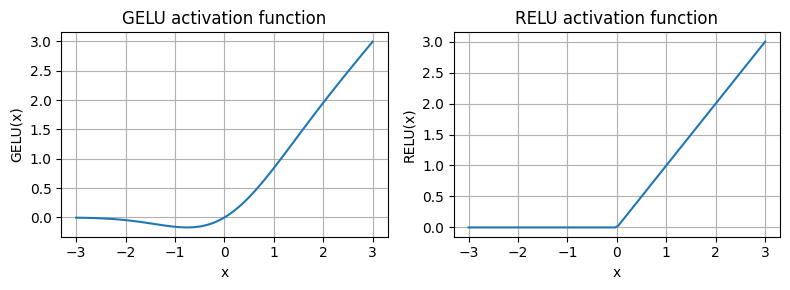

In [140]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3,3,100)
print(x)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i , (y, label) in enumerate(zip([y_gelu,y_relu],["GELU","RELU"]),1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [141]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

In [142]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layers(x)

In [143]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
print(x)
out = ffn(x)
print(out)
print(out.shape)

tensor([[[0.0351, 0.0028, 0.6470,  ..., 0.5897, 0.8112, 0.1335],
         [0.2758, 0.6665, 0.3312,  ..., 0.7204, 0.3365, 0.9016],
         [0.7622, 0.4008, 0.4706,  ..., 0.4857, 0.9844, 0.0499]],

        [[0.8761, 0.8123, 0.2511,  ..., 0.8113, 0.3147, 0.6469],
         [0.9920, 0.7436, 0.7393,  ..., 0.8690, 0.1667, 0.4374],
         [0.8999, 0.0747, 0.1878,  ..., 0.0586, 0.7915, 0.8741]]])
tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 768])


GPT ARCHITECTURE PART4 : SHORT CUT CONNECTIONS

In [144]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
    ])


  def forward(self,x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape==layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x


In [145]:
import torch
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.0,0.,-1.]])
torch.manual_seed(123)
model_wo_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [146]:
def print_gradients(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [147]:
print_gradients(model_wo_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [148]:
import torch
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.0,0.,-1.]])
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

In [149]:
print_gradients(model_with_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS

In [150]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

THE BUILDING BLOCKS : LAYER NORMALIZATION , GELU AND FEEDFORWARD

In [151]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(var+ self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

  def forward(self,x):
    return self.layers(x)

Coding the transformer block

In [152]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [153]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attn = MultiHeadAttention(d_in = cfg["emb_dim"],
                                   d_out = cfg["emb_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x


In [154]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:",x.shape)
print("Output shape:",output.shape)
print(output)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5034],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.1143],
         [ 0.7425,  0.4013,  0.3211,  ...,  0.3268,  0.7523, -0.1642],
         [ 0.5745,  0.6241,  0.4410,  ...,  1.1963,  1.2650,  0.2243]]],
       grad_fn=<AddBackward0>)


PART6 : GPT ARCHITECTURE  

In [155]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

In [156]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    #Use a placeholder transformer block
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Use a placeholder for Layer Norm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    print(batch_size)
    print(seq_len)
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

In [157]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps) # eps added to avoid divide by zero error while normalizing
    return self.scale * norm_x + self.shift


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

  def forward(self,x):
    return self.layers(x)

In [158]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attn = MultiHeadAttention(d_in = cfg["emb_dim"],
                                   d_out = cfg["emb_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

Entire GPT Architecture

In [159]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [160]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n",batch)
print("Output shape",out.shape)
print(out)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [161]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters:{total_params}")

Total number of parameters:163009536


In [162]:
print("Token embedding layer shape",model.tok_emb.weight.shape)
print("Positional embedding layer shape",model.pos_emb.weight.shape)
print("Output layer shape",model.out_head.weight.shape)

Token embedding layer shape torch.Size([50257, 768])
Positional embedding layer shape torch.Size([1024, 768])
Output layer shape torch.Size([50257, 768])


In [163]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print("Number of trainable parameters considering weight trying" ,total_params_gpt2)

Number of trainable parameters considering weight trying 124412160


In [164]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"total size of the model:{total_size_mb:2f} MB")

total size of the model:621.832031 MB


GPT ARCHITECTURE PART 7: GENERATING TEXT FROM TOKENS

In [165]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # Crop current context if it exceeds the supported context sixe
    # Ex if LLM Supports only 5 tokens, and the context size is 10 , then the last 5 tokens are used as context
    idx_cond = idx[:,-context_size:]

    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:] # taking the last token predictions for each batch in logits tensor.
    probas = torch.softmax(logits, dim=-1) # Redundant but gives additional intuition
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx,idx_next),dim=1)
  return idx




Sample example : "Hello , I am"

In [166]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Put model into eval mode as we are not training, dropout shall be disabled.

In [167]:
model.eval()
out = generate_text_simple(model=model, idx=encoded_tensor,max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output:",out)
print("Output length:",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [168]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


LLM Loss

In [169]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":256, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [170]:
import tiktoken

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model, idx = text_to_token_ids(start_context,tokenizer),max_new_tokens=10,context_size=GPT_CONFIG_124M["context_length"])
print(token_ids_to_text(token_ids,tokenizer))



Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Calculating the text generation loss :cross-entropy and perplexity

In [171]:
inputs = torch.tensor([[16833,3626,6100], #["every effort moves,"]
                       [40,1107,588]])    #"I really like"]
targets= torch.tensor([[3626,6100,345],  #["effort moves you",]
                       [1107,588,11311]]) #"really like chocolate"]

In [172]:
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape) # batch_size, num_tokens , vocab_dimension
print(probas)

torch.Size([2, 3, 50257])
tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0001,     0.0000]]])


In [173]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [174]:
print(f"Targets batch1 : {token_ids_to_text(targets[0],tokenizer)}")
print(f"Targets batch2 : {token_ids_to_text(targets[1],tokenizer)}")
print(f"Outputs batch1 : {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")
print(f"Outputs batch2 : {token_ids_to_text(token_ids[1].flatten(),tokenizer)}")

Targets batch1 :  effort moves you
Targets batch2 :  really like chocolate
Outputs batch1 :  Armed heNetflix
Outputs batch2 :  pressuring empoweredfaith


In [175]:
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text1:",target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text2:",target_probas_2)

Text1: tensor([    0.0001,     0.0000,     0.0000])
Text2: tensor([    0.0000,     0.0001,     0.0000])


In [176]:
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [177]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)


tensor(-10.7940)


In [178]:
neg_log_probas = avg_log_probas * -1
print(neg_log_probas)

tensor(10.7940)


In [179]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print("Flattened logits shape",logits_flat.shape)
print("Flattened targets shape",targets_flat.shape)
print("Flattened logits",logits_flat)
print("Flattened targets",targets_flat)

Flattened logits shape torch.Size([6, 50257])
Flattened targets shape torch.Size([6])
Flattened logits tensor([[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
        [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
        [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217],
        [-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
        [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
        [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]])
Flattened targets tensor([ 3626,  6100,   345,  1107,   588, 11311])


In [180]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [181]:
import os
with open("the-verdict.txt","r",encoding="utf-8") as file:
  text_data = file.read()
print(text_data[:99])
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [182]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:",total_characters)
print("Tokens:",total_tokens) # Text is very short for training an LLM but its for learning purposes only.

Characters: 20479
Tokens: 5145


In [183]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids = []
    self.target_ids = []

    #Tokenize the entire text
    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1 : i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):

  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)
  dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  # droplast - drops last batch if the size is less, shuffle - shuffles data for better generalization.
  return dataloader





In [184]:
GPT_CONFIG_124M = {"vocab_size":50257,
                   "context_length":256,
                   "emb_dim":768,
                   "n_heads":12,
                   "n_layers":12,
                   "drop_rate":0.1,
                   "qkv_bias":False}

In [185]:
#Train/Validation ratio

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(train_data,batch_size=2,max_length = GPT_CONFIG_124M["context_length"],stride=GPT_CONFIG_124M["context_length"],drop_last=True,shuffle=True,num_workers=0 )
val_loader = create_dataloader_v1(val_data,batch_size=2,max_length = GPT_CONFIG_124M["context_length"],stride=GPT_CONFIG_124M["context_length"],drop_last=True,shuffle=True,num_workers=True)

In [186]:
#Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the training loader"
  "Try to lower the context length or increase the training ratio")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the validation loader"
  "Try to lower the context length or decrease the training ratio")

In [187]:
#To check data loaded correctly

print("Train loader")
for x, y in train_loader:
  print(x.shape,y.shape)

print("Val loader")
for x, y in val_loader:
  print(x.shape,y.shape)

print(len(train_loader))

Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Val loader
torch.Size([2, 256]) torch.Size([2, 256])
9


In [188]:
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens +=input_batch.numel()

val_tokens = 9
for input_batch, target_batch in val_loader:
  val_tokens += input_batch.numel()

print("Training tokens:",train_tokens)
print("Validation tokens:",val_tokens)
print("All tokens:",train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 521
All tokens: 5129


In [189]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); #Disable dropout during inference

In [190]:
#Implementing loss
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) ==0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches,len(data_loader))

  for i , (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss/ num_batches


In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader,model, device)
print("Training loss",train_loss)
print("Validation loss",val_loss)

cuda
Training loss 10.98758347829183
Validation loss 10.98110580444336


TRAINING LOOP FOR THE LLM

In [192]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context,tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model, idx = encoded, max_new_tokens=50, context_size = context_size)
  decoded_text = token_ids_to_text(token_ids,tokenizer)
  print(decoded_text.replace("\n"," "))
  model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [],[],[]
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad() # Reset loss gradients from previous batch iteration
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1


      #Optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader,val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step :06f}:)"
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    generate_and_print_sample(
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen





In [193]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay= 0.1 )

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, eval_freq=5, eval_iter=5,
                                                           start_context = "Every effort moves you", tokenizer=tokenizer)
end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Execution time: {execution_time_minutes:.2f} minutes")



Ep 1 (Step 0.000000:)Train loss 9.818, Val loss 9.930
Ep 1 (Step 5.000000:)Train loss 7.920, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 10.000000:)Train loss 6.585, Val loss 7.046
Ep 2 (Step 15.000000:)Train loss 5.984, Val loss 6.598
Every effort moves you, the, and, the, the, the, and, the. ", the,,, the, and, the,, the,, the, and, the, the,, the, and,,,,, the
Ep 3 (Step 20.000000:)Train loss 15.871, Val loss 15.947
Ep 3 (Step 25.000000:)Train loss 5.578, Val loss 6.453
Every effort moves you. Gis. Gis. Gis. Gis. G. I had to----, and--. I had to--. I had. I had to the his--. I had the to the ", and I had.
Ep 4 (Step 30.000000:)Train loss 5.009, Val loss 6.335
Ep 4 (Step 35.000000:)Train loss 4.767, Val loss 6.249
Every effort moves you, and I had been the, I had to the picture. ", I had been--I, I had been the to the of the, I had the to the, I had been, I had the picture. ", I
Ep 5 (Step 40.000000:)Train loss 4.222, Val loss 6.

Model is overfitting as the dataset is too small.

In [194]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [195]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




DECODING STRATEGY : TEMPERATURE SCALING

In [196]:
vocab = {"closer":0,
         "every":1,
         "effort":2,
         "forward":3,
         "inches":4,
         "moves":5,
         "pizza":6,
         "toward":7,
         "you":8}

inverse_vocab = {v:k for k,v in vocab.items()}


In [197]:
# Assume input isn "every effort moves you" and generates the following as next token logits.

next_token_logits = torch.tensor([4.51,0.89,-1.90,6.75,1.63,-1.62,-1.89,6.28,1.79])
probas = torch.softmax(next_token_logits,dim=0)
print(probas)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
forward


In [198]:
torch.manual_seed(123)
new_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [199]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas,num_samples=1).item() for i in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i , freq in enumerate(sampled_ids):
    print(f"{freq} * {inverse_vocab[i]}")
print_sampled_tokens(probas)


73 * closer
0 * every
0 * effort
582 * forward
2 * inches
0 * moves
0 * pizza
343 * toward


In [200]:
def softmax_with_temperature(logits,temperature):
  scaled_logits = logits/temperature
  return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [ softmax_with_temperature(next_token_logits,T) for T in temperatures]


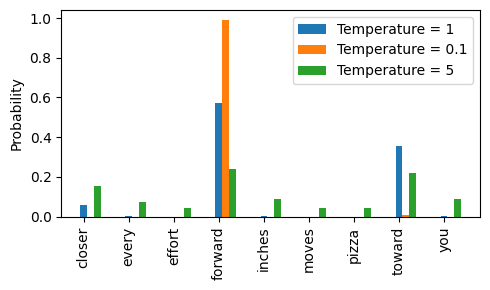

In [201]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

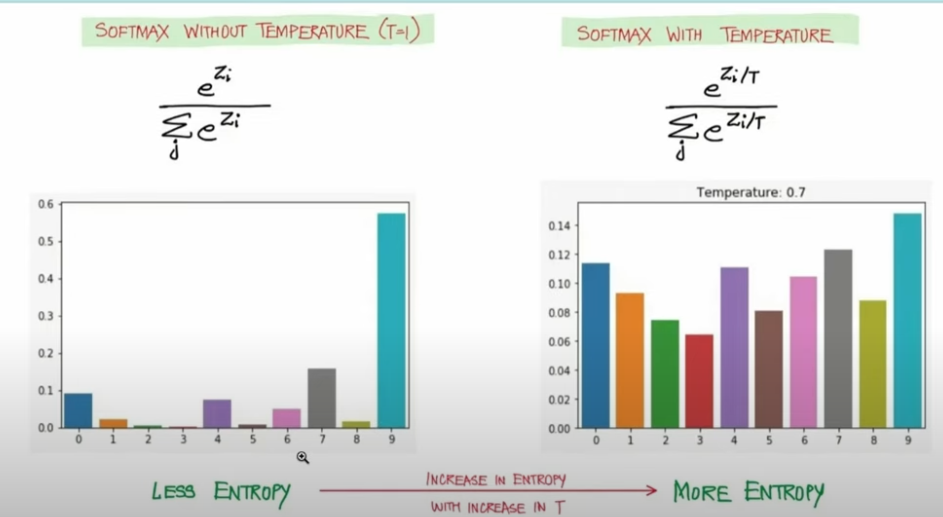

In [202]:
next_token_logits = torch.tensor([4.51,0.89,-1.90,6.75,1.63,-1.62,-1.89,6.28,1.79])

In [203]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits,top_k)
print("Top logits",top_logits)
print("Top positions",top_pos)

Top logits tensor([6.7500, 6.2800, 4.5100])
Top positions tensor([3, 7, 0])


In [204]:
new_logits = torch.where(condition= next_token_logits < top_logits[-1],
                         input = torch.tensor(float('-inf')),
                         other = next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [205]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


TOPK SAMPLING + TEMPERATURE SCALING

In [206]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [207]:
torch.manual_seed(123)

token_ids = generate(model=model,
                     idx = text_to_token_ids("Every effort moves you",tokenizer),
                     max_new_tokens=15,
                     context_size = GPT_CONFIG_124M["context_length"],
                     top_k = 25,
                     temperature=1.4)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

" surprise, a--because he knew me by his knees


LOADING AND SAVING MODEL WEIGHTS IN PYTORCH

In [208]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(),'model.pth')

LOADING THE MODEL into a new GPT Model

In [209]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [210]:
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004, weight_decay=0.1)
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },"model_and_optimizer.pth")

CHECKPOINT

In [211]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-4,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

LOADING PRETRAINED WEIGHTS FROM OPENAI

In [212]:
pip install tensorflow>=2.15.0 tqdm>=4.66

In [213]:
import tensorflow as tf
import tqdm

print("Tensor flow version",tf.__version__)
print("tqdm version",tqdm.__version__)



Tensor flow version 2.19.0
tqdm version 4.67.1


In [214]:
from gpt_download3 import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


INSPECTING SETTINGS AND PARAMETERS


In [215]:
print("Settings:",settings)
print("Parameter dictionary keys:",params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [216]:
print(params["wte"])
print("Token embedding weight tensor dimensions:",params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [217]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600,"n_layers":48,"n_heads":25}
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
print(NEW_CONFIG)


{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [218]:
NEW_CONFIG.update({"context_length":1024,"qkv_bias":True}) # Bias not generally used as they don't improve model performance, however used here to match original gpt settings.
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [219]:
import numpy as np

def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Leff :{left.shape}, Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [220]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [221]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [222]:
torch.manual_seed(123)

token_ids = generate(model=gpt,
                     idx = text_to_token_ids("Every effort moves you",tokenizer).to(device),
                     max_new_tokens=25,
                     context_size = GPT_CONFIG_124M["context_length"],
                     top_k = 50,
                     temperature=1.5)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


In [223]:
torch.manual_seed(123)

token_ids = generate(model=gpt,
                     idx = text_to_token_ids("Life is like",tokenizer).to(device),
                     max_new_tokens=25,
                     context_size = GPT_CONFIG_124M["context_length"],
                     top_k = 50,
                     temperature=1.4)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Life is like the old game – you're trapped where the rules of your world of living are wrong, stuck somewhere else; you're trapped


FINETUNING LLM

In [224]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [225]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t",header=None, names=["Label","Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [226]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [227]:
def create_balanced_dataset(df):
  num_spam = df[df["Label"] =="spam"].shape[0]
  ham_subset = df[df["Label"]=="ham"].sample(num_spam,random_state=123)
  balanced_df = pd.concat([ham_subset,df[df["Label"]=="spam"]])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [228]:
balanced_df["Label"]= balanced_df["Label"].map({"ham":0,"spam":1})

In [229]:
# 70% training , 10% validation , 20% testing
def random_split(df, train_frac, validation_frac):
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)

  #Calculate split indices
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(balanced_df,0.7,0.1)

In [230]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [231]:
train_df.to_csv("train.csv",index=False)
validation_df.to_csv("validation.csv",index=False)
test_df.to_csv("test.csv",index=False)

DATALOADERS

In [232]:
import torch
from torch.utils.data import Dataset

class SpamDataSet(Dataset):
  def __init__(self,csv_file, tokenizer, max_length=None, pad_token_id = 50256):
    self.data = pd.read_csv(csv_file)

    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data["Text"]
    ]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length

      self.encoded_texts = {encoded_text[:self.max_length]
                            for encoded_text in self.encoded_texts}

    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]

  def __getitem__(self,index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded, dtype = torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length
    return max_length

  def __len__(self):
    return len(self.data)



In [233]:
train_dataset = SpamDataSet(csv_file = "train.csv",
                            max_length = None,
                            tokenizer = tokenizer)
print(train_dataset.max_length)

val_dataset = SpamDataSet(csv_file = "validation.csv",
                            max_length = None,
                            tokenizer = tokenizer)
print(val_dataset.max_length)

test_dataset = SpamDataSet(csv_file = "test.csv",
                            max_length = None,
                            tokenizer = tokenizer)
print(test_dataset.max_length)

120
71
92


In [234]:
from torch.utils.data import DataLoader

batch_size = 16 # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_size = 16 # Choose an appropriate batch size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

batch_size = 16 # Choose an appropriate batch size
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

INITIALIZING A MODEL WITH PRETRAINED WEIGHTS



In [235]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600,"n_layers":48,"n_heads":25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"],(
    f"Dataset length {train_dataset.max_length} exceeds model's context"
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with"
    f"max_length = {BASE_CONFIG['context_length']}"
)

model = GPTModel(BASE_CONFIG)
model.load_state_dict(gpt.state_dict())
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [236]:
text1 = "Every effort moves you"

token_ids = generate_text_simple(model = model, idx = text_to_token_ids(text1, tokenizer), max_new_tokens = 15, context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [237]:
text2 = "Is the following text 'spam'? Answer with 'yes' or 'no':"
"'You are a winner you have been specially selected to receive $1000 cash or a $2000 award"

token_ids = generate_text_simple(model = model, idx = text_to_token_ids(text2, tokenizer), max_new_tokens = 23, context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids,tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no':

'spam' is a term used to describe a type of spam that is not spamming.



ADDING A CLASSIFICATION HEAD

In [238]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

FREESING THE MODEL

In [239]:
for param in model.parameters():
  param.requires_grad = False

In [240]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"],out_features=num_classes)

for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True

for param in model.final_norm.parameters():
  param.requires_grad = True

In [241]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs",inputs)
print("Inputs dimensions:",inputs.shape)

Inputs tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [242]:
with torch.no_grad():
  outputs = model(inputs)

print("Outputs:\n",outputs)
print("Outputs dimensions",outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions torch.Size([1, 4, 2])


In [243]:
print("Last output token:",outputs[:,-1,:])

Last output token: tensor([[-3.5983,  3.9902]])


OBTAINING CLASS LABEL

In [244]:
probas = torch.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas)
print("Class label:",label.item())

Class label: 1


In [245]:
logits = outputs[:,-1,:]
label = torch.argmax(logits)
print("Class label:",label.item())

Class label: 1


CALCULATING ACCURACY

In [246]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i , (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:,-1,:]
      predicted_labels = torch.argmax(logits, dim = -1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()
    else:
      break

  accuracy = correct_predictions / num_examples
  return accuracy




In [247]:
print(train_loader)
print(val_loader)
print(test_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches = 10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.4875
Validation accuracy: 0.5302
Test accuracy: 0.5312


In [248]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device) , target_batch.to(device)
  logits = model(input_batch)[:,-1,:]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [249]:
def calc_loss_loader(data_loader,model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) ==0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches


In [250]:
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

FINETUNING THE MODEL ON SUPERVISED DATA

In [251]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [252]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [253]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 15
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.559, Val loss 2.583
Ep 1 (Step 000050): Train loss 0.631, Val loss 0.608
Training accuracy: 37.50% | Validation accuracy: 82.50%
Ep 2 (Step 000100): Train loss 0.519, Val loss 0.645
Training accuracy: 72.50% | Validation accuracy: 62.50%
Ep 3 (Step 000150): Train loss 0.393, Val loss 0.705
Training accuracy: 85.00% | Validation accuracy: 66.25%
Ep 4 (Step 000200): Train loss 0.459, Val loss 0.726
Ep 4 (Step 000250): Train loss 0.288, Val loss 0.484
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 5 (Step 000300): Train loss 0.136, Val loss 0.333
Training accuracy: 85.00% | Validation accuracy: 77.50%
Ep 6 (Step 000350): Train loss 0.243, Val loss 0.376
Training accuracy: 98.75% | Validation accuracy: 91.25%
Ep 7 (Step 000400): Train loss 0.075, Val loss 0.211
Ep 7 (Step 000450): Train loss 0.058, Val loss 0.230
Training accuracy: 97.50% | Validation accuracy: 91.25%
Ep 8 (Step 000500): Train loss 0.056, Val loss 0.222
Training accuracy: 93.75%

In [254]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

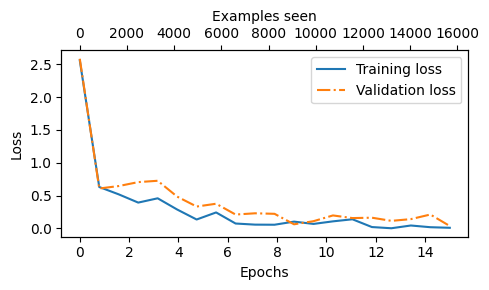

In [255]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

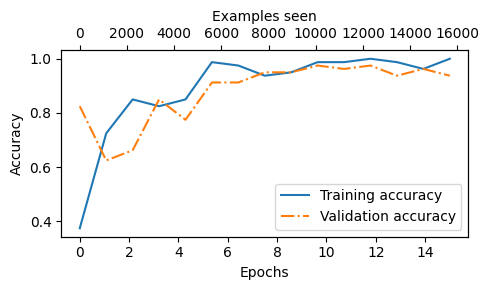

In [256]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [257]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.43%
Validation accuracy: 95.30%
Test accuracy: 95.00%


In [258]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id = 50256):
  input_ids = tokenizer.encode(text)
  supported_context_length = model.pos_emb.weight.shape[0]

  input_ids = input_ids[:min(max_length, supported_context_length)]

  input_ids += [pad_token_id] * (max_length - len(input_ids))
  input_tensor = torch.tensor(input_ids, device = device).unsqueeze(0)

  with torch.no_grad():
    logits = model(input_tensor)[:,-1,:]
  predicted_label = torch.argmax(logits, dim=-1).item()

  return "spam" if predicted_label == 1 else "ham"



In [259]:
text1= (
    "You are a winner you have specially"
    " selected to receive $2000 cash or a $500 reward"
)

print(classify_review(text1,model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [260]:
text2 = ("Hey, lets have dinner tonight ")
print(classify_review(text2,model, tokenizer, device, max_length=train_dataset.max_length))

ham
